# Run PESTPP-IES using a variety of available localization techniques

In [1]:
%matplotlib inline
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['font.size']=12
import flopy
import pyemu
%matplotlib inline

flopy is installed in /Users/jwhite/Dev/gw1876/activities_stpete/notebooks/flopy


## SUPER IMPORTANT: SET HOW MANY PARALLEL WORKERS TO USE

In [2]:
num_workers = 20

In [3]:
t_d = "template_history"
m_d = "master_ies"

In [4]:
m = flopy.modflow.Modflow.load("freyberg.nam",model_ws=t_d,check=False,forgive=False)

/Users/jwhite/Dev/gw1876/activities_stpete/notebooks/flopy/plot/map.py:1415: PendingDeprecationWarning: ModelMap will be replaced by PlotMapView(); Calling PlotMapView()
  warnings.warn(err_msg, PendingDeprecationWarning)


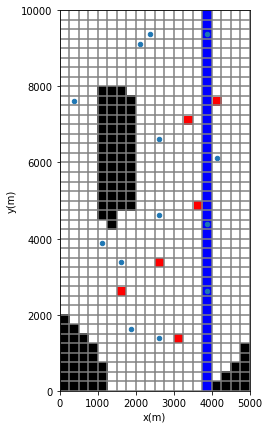

In [5]:
# plot some model attributes
fig = plt.figure(figsize=(12,7))
ax = plt.subplot(111,aspect="equal")
mm = flopy.plot.ModelMap(model=m)
mm.plot_grid()
mm.plot_ibound()
mm.plot_bc('SFR')
ax = mm.ax
#m.wel.stress_period_data.plot(ax=ax,mflay=2)

# plot obs locations
obs = pd.read_csv(os.path.join("..","base_model_files","obs_loc.csv"))
                  
obs_x = [m.sr.xcentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
obs_y = [m.sr.ycentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
ax.scatter(obs_x,obs_y,marker='.',label="water-level obs",s=80)

#plot names on the pumping well locations
wel_data = m.wel.stress_period_data[0]
wel_x = m.sr.xcentergrid[wel_data["i"],wel_data["j"]]
wel_y = m.sr.ycentergrid[wel_data["i"],wel_data["j"]]
for i,(x,y) in enumerate(zip(wel_x,wel_y)):
    ax.scatter([x],[y],color="red",marker="s",s=50)
    #ax.text(x,y,"{0}".format(i+1),ha="center",va="center")

ax.set_ylabel("y(m)")
ax.set_xlabel("x(m)")
plt.show()

In [ ]:
pst = pyemu.Pst(os.path.join(t_d,"freyberg.pst"))
#pst.write_par_summary_table(filename="none")

In [ ]:
#pst.pestpp_options = {}
pst.pestpp_options["ies_num_reals"] = 100  # enough?
pst.pestpp_options["ies_par_en"] = "prior.jcb"
pst.pestpp_options["ies_bad_phi_sigma"] = 1.75
pst.pestpp_options["overdue_giveup_fac"] = 1.5
pst.pestpp_options["ies_save_rescov"] = True
pst.control_data.noptmax = 3
pst.pestpp_options["ies_drop_conflicts"] = True
pst.pestpp_options["ies_pdc_sigma_distance"] = 2.0
pst.pestpp_options["ies_no_noise"] = True
pst.write(os.path.join(t_d,"freyberg_ies.pst"))


### PESTPP-IES with simple temporal localization (and common sense)

Now let's add some localization.  The obvious stuff is temporal - scenario parameters can't influence historic observations (and the inverse is true) so let's tell PESTPP-IES about this.  Also, should porosity be adjusted at all given the observations we have???

In [ ]:
arr_df = pd.read_csv(os.path.join(t_d,"arr_pars.csv"),index_col=0)
arr_df = arr_df.loc[arr_df.model_file.apply(lambda x: "rech" in x),:]
arr_df.head()

In [ ]:
# find which recharge par groups apply across all stress periods
vc = arr_df.prefix.value_counts()
vc = vc[vc > 1]
broadcast_rch_prefixes = list(vc.index.values)
broadcast_rch_prefixes

In [ ]:
arr_df = arr_df.loc[arr_df.prefix.apply(lambda x: x not in broadcast_rch_prefixes),:]

In [ ]:
arr_df.head()

In [ ]:
arr_df.loc[:,"kper"] = arr_df.model_file.apply(lambda x: int(x.split('.')[1].split('_')[1]))
rch_kper = {prefix:kper for kper,prefix in zip(arr_df.kper,arr_df.prefix)}

In [ ]:
par = pst.parameter_data
loc_matrix_cols = [g for g in pst.adj_par_groups if "hk" in g or "vk" in g 
                   or "ss" in g or "sy" in g or "pr" in g or "cond" in g or "strk" in g or "strt" in g
                  or "welflux_k02" in g or "flow" in g]
broadcast_rch_groups = [g for g in pst.adj_par_groups if True in [g.endswith(prefix) for prefix in broadcast_rch_prefixes]]
loc_matrix_cols.extend(broadcast_rch_groups)
static_loc_cols = loc_matrix_cols.copy()
static_pars = par.loc[par.pargp.apply(lambda x: x in loc_matrix_cols),"parnme"]
dont_groups = [g for g in loc_matrix_cols if "pr" in g]
temporal_pars = par.loc[par.pargp.apply(lambda x: x not in loc_matrix_cols),"parnme"]
loc_matrix_cols.extend(list(temporal_pars.values))
tpar_kper = {}
m = flopy.modflow.Modflow.load("freyberg.nam",model_ws=t_d,check=False)
dts = pd.to_datetime(m.start_datetime) + pd.to_timedelta(np.cumsum(m.dis.perlen.array),unit="d")
dts -= pd.to_timedelta(1,unit='d')
#print(dts)
tpar_dt = {}
for tpar in temporal_pars:
    if "welflux" in tpar:
        kper = int(tpar.split('_')[1])
    elif "rech" in tpar:
        kper = rch_kper[tpar.split('_')[1]]
    else:
        raise Exception(tpar)
    dt = dts[kper]
    tpar_dt[tpar] = dt
    

In [ ]:
nz_obs = pst.observation_data.loc[pst.nnz_obs_names,:]
nz_obs.loc[:,"datetime"] = pd.to_datetime(nz_obs.obsnme.apply(lambda x: x.split('_')[-1]))
loc = pyemu.Matrix.from_names(pst.nnz_obs_names,loc_matrix_cols).to_dataframe()
loc.loc[:,:]= 0.0
loc.loc[:,static_loc_cols] = 1.0
loc.loc[:,dont_groups] = 0.0
lower = pd.to_timedelta(0,unit='d')
upper = pd.to_timedelta(180,unit='d')
for pname,dt in tpar_dt.items():
    d = nz_obs.datetime - dt
    d = d[d.apply(lambda x: x>lower and x<upper)]
    loc.loc[d.index,pname] = 1.0
#loc.loc[:,dont_groups] = 0.0
pyemu.Matrix.from_dataframe(loc).to_ascii(os.path.join(t_d,"loc.mat"))

In [ ]:
pst.pestpp_options["ies_localizer"] = "loc.mat"
pst.write(os.path.join(t_d,"freyberg_ies.pst"))
pyemu.os_utils.start_workers(t_d,"pestpp-ies","freyberg_ies.pst",num_workers=num_workers,master_dir=m_d)

In [ ]:
phi = pd.read_csv(os.path.join(m_d,"freyberg_ies.phi.actual.csv"),index_col=0)
phi.index = phi.total_runs
phi.iloc[:,6:].apply(np.log10).plot(legend=False,lw=0.5,color='k')
plt.ylabel('log $\Phi$')
plt.show()
phi.iloc[-1,6:].hist()
plt.title('Final $\Phi$ Distribution');

In [ ]:
oe_pr = pd.read_csv(os.path.join(m_d,"freyberg_ies.0.obs.csv"),index_col=0)
oe_pt = pd.read_csv(os.path.join(m_d,"freyberg_ies.{0}.obs.csv".format(pst.control_data.noptmax)),index_col=0)
obs = pst.observation_data
fnames = pst.pestpp_options["forecasts"].split(",")
for forecast in fnames:
    fig,ax = plt.subplots(1,1,figsize=(10,5))
    oe_pr.loc[:,forecast].hist(ax=ax,color="0.5",alpha=0.5, label='prior')
    oe_pt.loc[:,forecast].hist(ax=ax,color="b",alpha=0.5, label='posterior')
    ax.plot([obs.loc[forecast,"obsval"],obs.loc[forecast,"obsval"]],ax.get_ylim(),"r", label='truth')
    ax.set_title(forecast)
    ax.legend(loc='upper right')
    plt.show()

In [ ]:
nz_obs = pst.observation_data.loc[pst.nnz_obs_names,:].copy()
nz_obs.loc[:,"datetime"] = pd.to_datetime(nz_obs.obsnme.apply(lambda x: x.split("_")[-1]))
pst_base = pyemu.Pst(os.path.join(t_d,"freyberg.pst"))
oe_base = pd.read_csv(os.path.join(m_d,"freyberg_ies.base.obs.csv"),index_col=0)
for nz_group in pst.nnz_obs_groups:
    nz_obs_group = nz_obs.loc[nz_obs.obgnme==nz_group,:]
    fig,ax = plt.subplots(1,1,figsize=(10,2))
    ax.plot(nz_obs_group.datetime,nz_obs_group.obsval,"r-")
    pdc_obs = nz_obs_group.loc[nz_obs_group.obsnme.apply(lambda x: rw_obs[x]==0),:]
   
    ax.scatter(pdc_obs.datetime,pdc_obs.obsval,marker='.',s=50,zorder=20,color='k',ls='-',lw=2,fc="k")
    [ax.plot(nz_obs_group.datetime,oe_pr.loc[r,nz_obs_group.obsnme],color="0.5",lw=0.1) for r in oe_pr.index]
    [ax.plot(nz_obs_group.datetime,oe_pt.loc[r,nz_obs_group.obsnme],color="b",lw=0.1,alpha=0.5) for r in oe_pt.index]
    #[ax.plot(nz_obs_group.datetime,oe_base.loc[r,nz_obs_group.obsnme],color="r",lw=0.1,alpha=0.5) for r in oe_base.index]
    mn = oe_base.loc[:,nz_obs_group.obsnme].min()
    mx = oe_base.loc[:,nz_obs_group.obsnme].max()
    
    ax.fill_between(nz_obs_group.datetime,mn,mx,fc="r",alpha=0.15)
    ax.set_title(nz_group)
    #vmin = min(nz_obs_group.obsval.min(),oe_pt.loc[:,nz_obs_group.obsnme].min().min())
    #vmax = max(nz_obs_group.obsval.max(),oe_pt.loc[:,nz_obs_group.obsnme].max().max())
    vmin = nz_obs_group.obsval.min() * 0.9
    vmax = nz_obs_group.obsval.max() * 1.1
    ax.set_ylim(vmin,vmax)
plt.show()

In [ ]:
pe_pr = pd.read_csv(os.path.join(m_d,"freyberg_ies.0.par.csv"),index_col=0)
pe_pt = pd.read_csv(os.path.join(m_d,"freyberg_ies.{0}.par.csv".format(pst.control_data.noptmax)),index_col=0)
#pe_pr.index = pe_pt.index
#par = pst.parameter_data
pe_pr = pe_pr.loc[pe_pr.index.intersection(pe_pt.index),:]
print(pe_pr.shape,pe_pt.shape)
pdict = par.groupby("pargp").groups
pyemu.plot_utils.ensemble_helper({"0.5":pe_pr,"b":pe_pt},plot_cols=pdict)
#pyemu.plot_utils.ensemble_change_summary(pe_pr,pe_pt,pst=pst,bins=20)

### PESTPP-IES with automatic adaptive localization

In [ ]:
pst.pestpp_options.pop("ies_localizer")
pst.pestpp_options["ies_autoadaloc"] = True
pst.write(os.path.join(t_d,"freyberg_ies.pst"))
pyemu.os_utils.start_workers(t_d,"pestpp-ies","freyberg_ies.pst",num_workers=num_workers,master_dir=m_d)

In [ ]:
phi = pd.read_csv(os.path.join(m_d,"freyberg_ies.phi.actual.csv"),index_col=0)
phi.index = phi.total_runs
phi.iloc[:,6:].apply(np.log10).plot(legend=False,lw=0.5,color='k')
plt.ylabel('log $\Phi$')
plt.show()
phi.iloc[-1,6:].hist()
plt.title('Final $\Phi$ Distribution');

In [ ]:
oe_pr_last = oe_pr.copy()
oe_pt_last = oe_pt.copy()
oe_pr = pd.read_csv(os.path.join(m_d,"freyberg_ies.0.obs.csv"),index_col=0)
oe_pt = pd.read_csv(os.path.join(m_d,"freyberg_ies.{0}.obs.csv".format(pst.control_data.noptmax)),index_col=0)
obs = pst.observation_data
fnames = pst.pestpp_options["forecasts"].split(",")
for forecast in fnames:
    fig,[ax,ax_last] = plt.subplots(1,2,figsize=(10,5))
    oe_pr.loc[:,forecast].hist(ax=ax,color="0.5",alpha=0.5, label='prior')
    oe_pt.loc[:,forecast].hist(ax=ax,color="b",alpha=0.5, label='posterior')
    ax.plot([obs.loc[forecast,"obsval"],obs.loc[forecast,"obsval"]],ax.get_ylim(),"r", label='truth')
    ax.set_title(forecast)
    ax.legend(loc='upper right')
    
    oe_pr_last.loc[:,forecast].hist(ax=ax_last,color="0.5",alpha=0.5, label='prior')
    oe_pt_last.loc[:,forecast].hist(ax=ax_last,color="b",alpha=0.5, label='posterior')
    ax_last.plot([obs.loc[forecast,"obsval"],obs.loc[forecast,"obsval"]],ax.get_ylim(),"r", label='truth')
    ax_last.set_title("last " + forecast)
    ax.legend(loc='upper right')
    plt.show()

In [ ]:
nz_obs = pst.observation_data.loc[pst.nnz_obs_names,:].copy()
nz_obs.loc[:,"datetime"] = pd.to_datetime(nz_obs.obsnme.apply(lambda x: x.split("_")[-1]))
pst_base = pyemu.Pst(os.path.join(t_d,"freyberg.pst"))
oe_base = pd.read_csv(os.path.join(m_d,"freyberg_ies.base.obs.csv"),index_col=0)
for nz_group in pst.nnz_obs_groups:
    nz_obs_group = nz_obs.loc[nz_obs.obgnme==nz_group,:]
    fig,ax = plt.subplots(1,1,figsize=(10,2))
    ax.plot(nz_obs_group.datetime,nz_obs_group.obsval,"r-")
    pdc_obs = nz_obs_group.loc[nz_obs_group.obsnme.apply(lambda x: rw_obs[x]==0),:]
   
    ax.scatter(pdc_obs.datetime,pdc_obs.obsval,marker='.',s=50,zorder=20,color='k',ls='-',lw=2,fc="k")
    [ax.plot(nz_obs_group.datetime,oe_pr.loc[r,nz_obs_group.obsnme],color="0.5",lw=0.1) for r in oe_pr.index]
    [ax.plot(nz_obs_group.datetime,oe_pt.loc[r,nz_obs_group.obsnme],color="b",lw=0.1,alpha=0.5) for r in oe_pt.index]
    #[ax.plot(nz_obs_group.datetime,oe_base.loc[r,nz_obs_group.obsnme],color="r",lw=0.1,alpha=0.5) for r in oe_base.index]
    mn = oe_base.loc[:,nz_obs_group.obsnme].min()
    mx = oe_base.loc[:,nz_obs_group.obsnme].max()
    
    ax.fill_between(nz_obs_group.datetime,mn,mx,fc="r",alpha=0.15)
    ax.set_title(nz_group)
    #vmin = min(nz_obs_group.obsval.min(),oe_pt.loc[:,nz_obs_group.obsnme].min().min())
    #vmax = max(nz_obs_group.obsval.max(),oe_pt.loc[:,nz_obs_group.obsnme].max().max())
    vmin = nz_obs_group.obsval.min() * 0.9
    vmax = nz_obs_group.obsval.max() * 1.1
    ax.set_ylim(vmin,vmax)
plt.show()

In [ ]:
pe_pr = pd.read_csv(os.path.join(m_d,"freyberg_ies.0.par.csv"),index_col=0)
pe_pt = pd.read_csv(os.path.join(m_d,"freyberg_ies.{0}.par.csv".format(pst.control_data.noptmax)),index_col=0)
#pe_pr.index = pe_pt.index
#par = pst.parameter_data
pe_pr = pe_pr.loc[pe_pr.index.intersection(pe_pt.index),:]
print(pe_pr.shape,pe_pt.shape)
pdict = par.groupby("pargp").groups
pyemu.plot_utils.ensemble_helper({"0.5":pe_pr,"b":pe_pt},plot_cols=pdict)
#pyemu.plot_utils.ensemble_change_summary(pe_pr,pe_pt,pst=pst,bins=20)

### PESTPP-IES with par-by-par distance based localization


In [ ]:
m = flopy.modflow.Modflow.load("freyberg.nam",model_ws=t_d)

In [ ]:
par = pst.parameter_data

gr_par = par.loc[par.pargp.apply(lambda x: "gr" in x and "prsity" not in x),:].copy()
print(gr_par.pargp.unique())
gr_par.groupby("pargp").groups
gr_par.loc[:,"i"] = gr_par.parnme.apply(lambda x: int(x[-6:-3]))
gr_par.loc[:,"j"] = gr_par.parnme.apply(lambda x: int(x[-3:]))
gr_par.loc[:,"x"] = gr_par.apply(lambda x: m.sr.xcentergrid[x.i,x.j],axis=1)
gr_par.loc[:,"y"] = gr_par.apply(lambda x: m.sr.ycentergrid[x.i,x.j],axis=1)

obs = pst.observation_data.loc[pst.nnz_obs_names,:]

nobs = obs.loc[obs.obsnme.apply(lambda x: x.startswith("trgw")),:].copy()
nobs.loc[:,"i"] = nobs.obsnme.apply(lambda x: int(x.split('_')[1]))
nobs.loc[:,"j"] = nobs.obsnme.apply(lambda x: int(x.split('_')[2]))
nobs.loc[:,"x"] = nobs.apply(lambda x: m.sr.xcentergrid[x.i,x.j],axis=1)
nobs.loc[:,"y"] = nobs.apply(lambda x: m.sr.ycentergrid[x.i,x.j],axis=1)
nobs.loc[:,"xy"] = nobs.apply(lambda x: "{0}_{1}".format(x.x,x.y),axis=1)

In [ ]:
pp_tpl = [f for f in os.listdir(t_d) if "pp" in f and f.endswith(".tpl")]
pp_tpl_dfs = [pyemu.pp_utils.pp_tpl_to_dataframe(os.path.join(t_d,f)) for f in pp_tpl]
pp_par = pd.concat(pp_tpl_dfs)
pp_par.index = pp_par.parnme
#pp_par = par.loc[par.pargp.apply(lambda x: "pp" in x),:].copy()
pp_par.head()

## We will set up localization such that parameters are only informed by observations within a user-specfied distance (we can use 5000 meters)

In [ ]:
spatial_loc = pyemu.Matrix.from_names(pst.nnz_obs_names,pst.adj_par_names).to_dataframe()
spatial_loc.values[:,:] = 1.0

loc_dist = 5000.0
sadj = set(pst.adj_par_names)
dont_pars = set(par.loc[par.pargp.apply(lambda x: x in dont_groups),"parnme"].tolist())

print('obsname            fraction grid retained   fraction pilot points retained')
xy_groups = nobs.groupby('xy').groups
print(len(xy_groups))
#for oname in nobs.obsnme:
for xy,onames in xy_groups.items():
    oname = onames[0]
    xx,yy = nobs.loc[oname,['x','y']]
    
    # localization for grid-based parameters
    gr_par.loc[:,"dist"] = gr_par.apply(lambda x: (x.x - xx)**2 + (x.y - yy)**2,axis=1).apply(np.sqrt)
    gr_too_far = gr_par.loc[gr_par.dist > loc_dist,"parnme"]
    gr_too_far = gr_too_far.loc[gr_too_far.apply(lambda x: x in sadj)]
    spatial_loc.loc[:,gr_too_far] = 0.0
    
    # localization for pilot point parameters
    pp_par.loc[:,"dist"] = pp_par.apply(lambda x: (x.x - xx)**2 + (x.y - yy)**2,axis=1).apply(np.sqrt)
    pp_too_far = pp_par.loc[pp_par.dist > loc_dist,"parnme"]
    pp_too_far = pp_too_far.loc[pp_too_far.apply(lambda x: x in sadj)]
    spatial_loc.loc[onames,pp_too_far] = 0.0
    print(oname,gr_too_far.shape[0]/gr_par.shape[0],pp_too_far.shape[0]/pp_par.shape[0])
    
#loc.loc[:,dont_pars] = 0.0
#spars = par.loc[par.parnme.apply(lambda x: "ss" in x or "sy" in x),"parnme"]
#loc.loc[:,spars] = 0.0
spatial_loc.loc[loc.index,temporal_pars] = loc.loc[:,temporal_pars]
print('\n\nTotal number of parameters still informed by each observation')
spatial_loc.sum(axis=1)

In [ ]:
pyemu.Matrix.from_dataframe(spatial_loc).to_coo(os.path.join(t_d,"spatial_loc.jcb"))
pst.pestpp_options["ies_localizer"] = "spatial_loc.jcb"
pst.pestpp_options["ies_num_threads"] = 10
pst.pestpp_options.pop("ies_autoadaloc")
pst.write(os.path.join(t_d,"freyberg_ies.pst"))

### now let's run it

In [ ]:
pyemu.os_utils.start_workers(t_d,"pestpp-ies","freyberg_ies.pst",num_workers=num_workers,master_dir=m_d)

In [ ]:
phi = pd.read_csv(os.path.join(m_d,"freyberg_ies.phi.actual.csv"),index_col=0)
phi.index = phi.total_runs
phi.iloc[:,6:].apply(np.log10).plot(legend=False,lw=0.5,color='k')
plt.ylabel('log $\Phi$')
plt.show()
phi.iloc[-1,6:].hist()
plt.title('Final $\Phi$ Distribution');

In [ ]:
oe_pr_last = oe_pr.copy()
oe_pt_last = oe_pt.copy()
oe_pr = pd.read_csv(os.path.join(m_d,"freyberg_ies.0.obs.csv"),index_col=0)
oe_pt = pd.read_csv(os.path.join(m_d,"freyberg_ies.{0}.obs.csv".format(pst.control_data.noptmax)),index_col=0)
obs = pst.observation_data
fnames = pst.pestpp_options["forecasts"].split(",")
for forecast in fnames:
    fig,[ax,ax_last] = plt.subplots(1,2,figsize=(10,5))
    oe_pr.loc[:,forecast].hist(ax=ax,color="0.5",alpha=0.5, label='prior')
    oe_pt.loc[:,forecast].hist(ax=ax,color="b",alpha=0.5, label='posterior')
    ax.plot([obs.loc[forecast,"obsval"],obs.loc[forecast,"obsval"]],ax.get_ylim(),"r", label='truth')
    ax.set_title(forecast)
    ax.legend(loc='upper right')
    
    oe_pr_last.loc[:,forecast].hist(ax=ax_last,color="0.5",alpha=0.5, label='prior')
    oe_pt_last.loc[:,forecast].hist(ax=ax_last,color="b",alpha=0.5, label='posterior')
    ax_last.plot([obs.loc[forecast,"obsval"],obs.loc[forecast,"obsval"]],ax.get_ylim(),"r", label='truth')
    ax_last.set_title("last " + forecast)
    ax.legend(loc='upper right')
    plt.show()

In [ ]:
nz_obs = pst.observation_data.loc[pst.nnz_obs_names,:].copy()
nz_obs.loc[:,"datetime"] = pd.to_datetime(nz_obs.obsnme.apply(lambda x: x.split("_")[-1]))
pst_base = pyemu.Pst(os.path.join(t_d,"freyberg.pst"))
oe_base = pd.read_csv(os.path.join(m_d,"freyberg_ies.base.obs.csv"),index_col=0)
for nz_group in pst.nnz_obs_groups:
    nz_obs_group = nz_obs.loc[nz_obs.obgnme==nz_group,:]
    fig,ax = plt.subplots(1,1,figsize=(10,2))
    ax.plot(nz_obs_group.datetime,nz_obs_group.obsval,"r-")
    pdc_obs = nz_obs_group.loc[nz_obs_group.obsnme.apply(lambda x: rw_obs[x]==0),:]
   
    ax.scatter(pdc_obs.datetime,pdc_obs.obsval,marker='.',s=50,zorder=20,color='k',ls='-',lw=2,fc="k")
    [ax.plot(nz_obs_group.datetime,oe_pr.loc[r,nz_obs_group.obsnme],color="0.5",lw=0.1) for r in oe_pr.index]
    [ax.plot(nz_obs_group.datetime,oe_pt.loc[r,nz_obs_group.obsnme],color="b",lw=0.1,alpha=0.5) for r in oe_pt.index]
    #[ax.plot(nz_obs_group.datetime,oe_base.loc[r,nz_obs_group.obsnme],color="r",lw=0.1,alpha=0.5) for r in oe_base.index]
    mn = oe_base.loc[:,nz_obs_group.obsnme].min()
    mx = oe_base.loc[:,nz_obs_group.obsnme].max()
    
    ax.fill_between(nz_obs_group.datetime,mn,mx,fc="r",alpha=0.15)
    ax.set_title(nz_group)
    #vmin = min(nz_obs_group.obsval.min(),oe_pt.loc[:,nz_obs_group.obsnme].min().min())
    #vmax = max(nz_obs_group.obsval.max(),oe_pt.loc[:,nz_obs_group.obsnme].max().max())
    vmin = nz_obs_group.obsval.min() * 0.9
    vmax = nz_obs_group.obsval.max() * 1.1
    ax.set_ylim(vmin,vmax)
plt.show()

In [ ]:
pe_pr = pd.read_csv(os.path.join(m_d,"freyberg_ies.0.par.csv"),index_col=0)
pe_pt = pd.read_csv(os.path.join(m_d,"freyberg_ies.{0}.par.csv".format(pst.control_data.noptmax)),index_col=0)
par = pst.parameter_data
pdict = par.groupby("pargp").groups
pyemu.plot_utils.ensemble_helper({"0.5":pe_pr,"b":pe_pt},plot_cols=pdict)
#pyemu.plot_utils.ensemble_change_summary(pe_pr,pe_pt,pst=pst,bins=20)